# Project

1. Setup
2. Data
3. Model
4. Inference
5. Submission

In [2]:
# Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# import necessary libaries

from fastai import *
from fastai.tabular import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# basic bash & create folder structure for Project

# !mkdir abc
# !echo "file" > abc/123.txt

# import os
# os.chdir('abc')

# # Now the directory 'abc' is the current working directory.
# # and will show 123.txt.
# !ls

# #change working directory
# %cd folder/folder

# # check 
# !pwd

In [4]:
# connect to kaggle

# from google.colab import files
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# # !pip install kaggle
# !chmod 600 /root/.kaggle/kaggle.json

## 2. Data

In [5]:
#list 

# list and download kaggle dataset
# ! kaggle competitions list -s bluebook
# ! kaggle competitions download -c 'name of data' -f 'train-jpg.tar.7z' -p {path where to download}

#download data
# !kaggle competitions download -c bluebook-for-bulldozers -p 'drive/My Drive/Colab Notebooks/kaggle/Bulldozer'


In [6]:
path = Path('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer')


In [7]:
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Data%20Dictionary.xlsx'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/TrainAndValid.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/ValidSolution.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Test.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Train.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Machine_Appendix.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Valid.csv.zip'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/TrainAndValid.7z'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/median_benchmark.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Valid.7z'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/kaggle/Bulldozer/Train.7z'),
 PosixPath('/content/drive/

In [8]:
train_df = pd.read_csv(path/'Train/Train.csv', low_memory=False, parse_dates=['saledate'])

test_df = pd.read_csv(path/'Test.csv.zip', low_memory = False, parse_dates=['saledate'])

valid_df = pd.read_csv(path/'Valid.csv.zip', low_memory= False, parse_dates=['saledate'])

In [9]:
# train_df.head()
# test_df.head()
valid_df.saledate.min()

Timestamp('2012-01-01 00:00:00')

In [10]:
len(train_df), len(test_df), len(valid_df)

(401125, 12457, 11573)

## 2.2 Data Preprocessing

- sort by date
- change saleprice to log (since metric RMSLE)

## 2.3 Feature Engineering 

-add_datepart()

In [11]:
train_df = train_df.sort_values(by = 'saledate', ascending=False)

train_df = train_df.reset_index(drop=True)
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,6269664,22000,1881427,7624,149,2.0,1000,NaN,NaN,2011-12-30,IT28,IT28,NaN,NaN,NaN,NaN,Wheel Loader - 100.0 to 110.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,6312170,11000,1812622,9580,149,2.0,2005,NaN,NaN,2011-12-30,T190,T190,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6265707,12500,1873075,43,149,2.0,1000,NaN,NaN,2011-12-30,416II,416,NaN,II,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,New York,BL,Backhoe Loaders,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6296711,27500,1918428,24719,149,2.0,1000,NaN,NaN,2011-12-30,436B,436,B,NaN,NaN,Medium,Wheel Loader - 175.0 to 200.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,6295141,21500,1805359,15972,149,2.0,2005,NaN,NaN,2011-12-30,8080ZTS,8080,NaN,NaN,ZTS,Small,"Hydraulic Excavator, Track - 8.0 to 11.0 Metri...",New York,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [12]:
# change Saleprice to log (since metric RMSLE)

train_df['SalePrice'] = np.log(train_df['SalePrice'])
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,6269664,9.998798,1881427,7624,149,2.0,1000,NaN,NaN,2011-12-30,IT28,IT28,NaN,NaN,NaN,NaN,Wheel Loader - 100.0 to 110.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,6312170,9.305651,1812622,9580,149,2.0,2005,NaN,NaN,2011-12-30,T190,T190,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6265707,9.433484,1873075,43,149,2.0,1000,NaN,NaN,2011-12-30,416II,416,NaN,II,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,New York,BL,Backhoe Loaders,Two Wheel Drive,EROPS,None or Unspecified,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6296711,10.221941,1918428,24719,149,2.0,1000,NaN,NaN,2011-12-30,436B,436,B,NaN,NaN,Medium,Wheel Loader - 175.0 to 200.0 Horsepower,New York,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,6295141,9.975808,1805359,15972,149,2.0,2005,NaN,NaN,2011-12-30,8080ZTS,8080,NaN,NaN,ZTS,Small,"Hydraulic Excavator, Track - 8.0 to 11.0 Metri...",New York,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Rubber,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [13]:
# feature engineering (add_datepart)

add_datepart(train_df, 'saledate', drop=False)
add_datepart(test_df, 'saledate', drop=False)

train_df.tail().T

,401120,401121,401122,401123,401124
SalesID,1508502,1421628,1475641,1475662,1646770
SalePrice,9.95228,11.2385,10.0648,9.9988,9.15905
MachineID,1153157,1453580,1194367,1242833,1126363
ModelID,4138,3877,7277,7277,8434
datasource,132,132,132,132,132
...,...,...,...,...,...
saleIs_quarter_end,False,False,False,False,False
saleIs_quarter_start,False,False,False,False,False
saleIs_year_end,False,False,False,False,False
saleIs_year_start,False,False,False,False,False


In [14]:
## Processing

procs = [FillMissing, Categorify, Normalize]


In [15]:
# get cat. and cont. colums

train_df.dtypes

cols = train_df.columns.to_series().groupby(train_df.dtypes).groups
cols


{int64: ['SalesID', 'MachineID', 'ModelID', 'datasource', 'YearMade', 'saleYear', 'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleElapsed'], float64: ['SalePrice', 'auctioneerID', 'MachineHoursCurrentMeter'], datetime64[ns]: ['saledate'], bool: ['saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start'], object: ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer'

In [16]:
cat_vars = ['SalesID', 'YearMade', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 
            'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 
            'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 
            'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 
            'saleYear', 'saleMonth', 'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 
            'saleIs_year_start'
           ]
cont_names = ["MachineHoursCurrentMeter", "saleElapsed"]
dep_var = 'SalePrice' 

# final df

df = train_df[cat_vars + cont_names + [dep_var, 'saledate']].copy()

# create Valid Set and make sure that dates are AFTER train-set

warum nicht das eigentlich valid_df nutzen ?

In [17]:
test_df['saledate'].min(), test_df['saledate'].max()

(Timestamp('2012-05-01 00:00:00'), Timestamp('2012-11-16 00:00:00'))

In [18]:
valid_df['saledate'].max(), valid_df['saledate'].min()

(Timestamp('2012-04-28 00:00:00'), Timestamp('2012-01-01 00:00:00'))

In [19]:
train_df['saledate'].max()

Timestamp('2011-12-30 00:00:00')

In [20]:
# to learn
cut = train_df['saledate'][(train_df['saledate'] == train_df['saledate'][len(test_df)])].index.max()
cut

12621

In [21]:
len(test_df)

12457

In [22]:
valid_idx = range(cut)
valid_idx

range(0, 12621)

In [23]:
# DataBunch

data = (TabularList
        .from_df(df, path= path, cont_names=cont_names, cat_names=cat_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls = FloatList).
        databunch())

# notes:
# label_from_df with label_cls=Floatlist so autom. regression
# no test_set added (probably since only now, after competition ended test_set availabel)
# maybe same for valid ?

In [24]:
data.show_batch(3)

SalesID,YearMade,MachineID,ModelID,datasource,auctioneerID,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,MachineHoursCurrentMeter_na,MachineHoursCurrentMeter,saleElapsed,target
1658658,1000,1355281,4956,132,6.0,#na#,645B,645,B,#na#,#na#,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Kentucky,WL,Wheel Loader,#na#,EROPS,Yes,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,1994,12,50,12,0,346,False,False,False,False,False,False,True,-0.0709,-1.6506,9.581903
1431685,1996,70766,1263,132,8.0,#na#,330BL,330,B,#na#,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons",Tennessee,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,2003,6,25,19,3,170,False,False,False,False,False,False,True,-0.0709,-0.1559,11.156251
2412338,1000,1484792,603,136,2.0,#na#,WA320-1,WA320,#na#,-1,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,Massachusetts,WL,Wheel Loader,#na#,EROPS,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,20.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,2009,9,37,12,5,255,False,False,False,False,False,False,False,-0.0709,0.9380,10.126631


## 3. Model

1. Build

y_range, layers, (tensor), dropout, emb_drop, metrics

2. Train
3. Fine-tune


In [25]:
y_range_max = df.SalePrice.max() * 1.2
y_range = torch.tensor([0, y_range_max], device=defaults.device)
y_range

tensor([ 0.0000, 14.2363])

In [26]:

learn = tabular_learner(data, layers=[1000, 500], ps=[1e-3, 1e-2],
                        emb_drop=0.04, y_range= y_range, metrics = rmse)
# learn.model

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


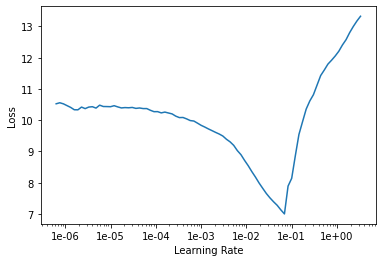

In [26]:
# Train

learn.lr_find()

In [ ]:
learn.recorder.plot(suggesstion=True)

In [27]:
lr_rate = 1e-2
learn.fit_one_cycle(2, lr_rate, wd=0.2, cbs=[SaveModelCallback(every_epoch=True, fname='bulldozer_stage1',
                                              ])

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.091379,0.076238,0.271652,21:17
1,0.053447,0.055794,0.232779,21:18


In [28]:
learn.save('1')

In [27]:
learn.load('1')

Learner(data=TabularDataBunch;

Train: LabelList (388504 items)
x: TabularList
SalesID 6273731; YearMade 2003; MachineID 787126; ModelID 3460; datasource 149; auctioneerID 1.0; UsageBand #na#; fiModelDesc 307C; fiBaseModel 307; fiSecondaryDesc C; fiModelSeries #na#; fiModelDescriptor #na#; ProductSize Mini; fiProductClassDesc Hydraulic Excavator, Track - 6.0 to 8.0 Metric Tons; state Florida; ProductGroup TEX; ProductGroupDesc Track Excavators; Drive_System #na#; Enclosure EROPS w AC; Forks #na#; Pad_Type #na#; Ride_Control #na#; Stick #na#; Transmission #na#; Turbocharged #na#; Blade_Extension #na#; Blade_Width #na#; Enclosure_Type #na#; Engine_Horsepower #na#; Hydraulics Standard; Pushblock #na#; Ripper #na#; Scarifier #na#; Tip_Control #na#; Tire_Size #na#; Coupler None or Unspecified; Coupler_System #na#; Grouser_Tracks #na#; Hydraulics_Flow #na#; Track_Type Rubber; Undercarriage_Pad_Width None or Unspecified; Stick_Length None or Unspecified; Thumb None or Unspecified; Pattern_Cha

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# from fastai.callback.all import *
import fastai
print('Using fastai version ',fastai.__version__)


In [34]:
lr_rate = 2.51E-03
learn.fit_one_cycle(3, slice(lr_rate), wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time


RuntimeError: ignored

In [ ]:
learn.save('bulldozer_stage2')

In [ ]:
learn.fit_one_cycle(4, slice(lr_rate), wd=0.2, 
                    # cbs=[SaveModelCallback(every_epoch=True, fname='bulldozer_stage2'),
                    #      EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2),
                    #      ReduceLROnPlateau(monitor='valid_loss', comp=None, min_delta=0.0, patience=1, factor=10.0, min_lr=0, reset_on_fit=True)
                    #      ]
                    )

epoch,train_loss,valid_loss,root_mean_squared_error,time


epoch,train_loss,valid_loss,root_mean_squared_error,time


In [ ]:
learn.save('bulldozer_stage3')

## 4. Submission

get sample_sub

to_csv

!kaggle competitions submit

In [ ]:

# test_df[''] = test_preds[0].data.numpy().T[0]
# test_df[['Id', '']] = test_df[['Id', 'Sales']].astype(int)
# test_df.Sales.dtype
# test_df[["Id", ""]].to_csv("submission.csv", index=False)


from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# !pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions list
# !kaggle competitions download -c [COMPETITION]
# !kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]

# !kaggle datasets list -s [KEYWORD]
# !kaggle datasets download -d [DATASET

## Submission

In [ ]:

#upload
!kaggle competitions submit "" -f '/content/drive/My Drive/Colab Notebooks/kaggle/ ------ion.csv' -m ''